# Importing packages 


In [4]:
# Array math 
import numpy as np 

# Iteration tracking 
from tqdm import tqdm

# Type hinting 
from typing import Tuple

# Plotting
import matplotlib.pyplot as plt
import matplotlib

# Q Learning 

Q learning is an off-policy TD algorithm to approximate the best optimal policy. 

Definitions: 

*Q value* - the value given for an action $a$ taken in state $s$. To put it more mathematically, it maps the actions and states to the real number plane: 

$$Q(a \in \mathbb{A}, s \in \mathbb{S}) \rightarrow q \in  \mathbb{R}$$

In practise, the bigger the q value for an action is, the "better" it is for the agent to take. 

*Q table* - a matrix storing the Q values where each row is a state and each column is an action. 

*$\epsilon$-greedy policy* - the policy where, at every decision point, the agent takes a random action with the probability of 1 - $\epsilon$ and the action which has the biggest q value with the probability of $\epsilon$, where $\epsilon \in [0, 1]$.

*off-policy algorithm* - algorithms where the agent updates it's policy not using it's behavior policy. 

*behavior policy* - the policy used by the agent to make an action.

Full algorithm for Q learning: 

1. Hyperparameters: 

1.1 Define step size $\alpha \in (0, 1]$

1.2 Define $\epsilon \in [0, 1]$

1.3 Define the discount factor $\gamma \in (0, 1]$

1.4 Initialize the Q table where all the values are arbitraty except for terminal states $Q(terminal, *) = 0$

1.5 Define the number of episodes $N$. 

2. Iterate for 1 to $N$:

2.1 Pick a starting state s.

2.2 Iterate until the agent reaches a terminal state: 

2.2.1 From the given state, pick an action $A$ using epsilon-greedy policy 

2.2.2 Take action $A$, observe the transition state $s^{'}$ and the reward $r$

**2.2.3 Update the current Q value estimate:** 

$$ Q(S, A) \leftarrow Q(S, A) + \alpha \left(r + \gamma \max_{a} Q(s^{'}, a) - Q(S, A)\right)$$

2.2.4 Set $s$ $\leftarrow$ $s^{'}$

The 2.2.3 update is the main part of the Q algorithm. 

As we can see, in step 2.2.1, the behavior policy is the epslion-greedy policy. 

But when we update the current Q value, we do not use that behaviour policy - we update the current Q value from the future state Q value and not use the epsilon-greedy policy anywhere. 

# Maze escape problem 

We will create a maze where: 

The agent starts at the bottom left corner of the maze. 

The goal is to reach the top right corner of the maze. 

In the middle of the maze we will generate some random wall blocks. 

When an agent tries to transition to a wall block, it will stay in the same state with a reward of -1. 

Every movement will give a reward of -0.1.

Reaching the goal state terminates the episode and returns a reward of 1. 

# Defining the ploting functions 

In [5]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

def plot_matrix(
    M: np.array, 
    goal_coords: list = [],
    hole_coords: list = [],
    start_coords: list = [],
    img_width: int = 5, 
    img_height: int = 5, 
    title: str = None,
    ) -> None: 
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    
    for x in range(height):
        for y in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            # If there is a tuple of (x, y) in the hole_coords list, we color the cell salmon
            elif (x, y) in hole_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='salmon'))
            # If there is a tuple of (x, y) in the start_coords list, we color the cell yellow
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.show()


# Defining the maze world 

In [6]:
def get_state_coords(s, S) -> tuple:
    """
    Returns the state coordinates given the state index
    """
    s_index = np.where(S == s)
    return s_index[0][0], s_index[1][0]

def init_maze(nrow: int, ncol: int, maze_density: int, seed: int) -> Tuple:
    """
    Creates an array of states in a maze environment.

    Returns
    -------
    maze : np.array
        A 2D array of states in a maze environment.
    wall_coords : list
        A 1D array of wall states in the maze environment.
    start_coords: tuple
        A tuple of start coordinates in the maze environment.
    goal_coords: tuple
        A tuple of goal coordinates in the maze environment.
    """
    # Setting the seed for reproducibility
    np.random.seed(seed)

    # Initiating the empty maze
    maze = np.arange(0, nrow * ncol).reshape(nrow, ncol)

    # Creating the wall states
    wall_states = np.random.choice(range(1, nrow * ncol), size=maze_density, replace=False)

    # Getting the list of wall coordinates
    wall_coords = [get_state_coords(s, maze) for s in wall_states]

    # Generating a starting state from the states that are NOT walls
    start_state = np.random.choice(np.setdiff1d(maze, wall_states))

    # Getting the starting coordinates
    start_coords = get_state_coords(start_state, maze)

    # Generating a goal state from the states that are NOT walls and NOT the starting state
    goal_state = np.random.choice(np.setdiff1d(np.setdiff1d(maze, wall_states), start_state))

    # Getting the goal coordinates
    goal_coords = get_state_coords(goal_state, maze)

    # return maze, wall_states
    return maze, wall_coords, [start_coords], [goal_coords]

In [7]:
maze, walls, start, goal = init_maze(6, 6, 8, 40)

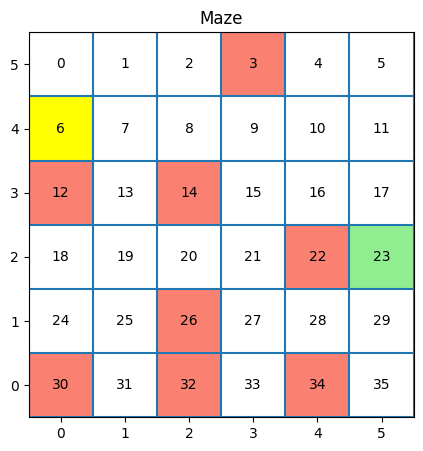

In [8]:
plot_matrix(maze, goal_coords=goal, hole_coords=walls, start_coords=start, title="Maze")

# The policy and the movement rules 

The policy will be uniform and the agent can move in any direction with equal probabilities. 

If an agent tries to move to a wall block, it will stay in the same state.

If the agent tries to go out of bounds - it will stay in the same state.

When the agent reaches its goal state, the episode terminates and the agent is returned to the starting state. 

# The agent 

The agent will be an object created by the class `Agent`. All the uptades of the q table will be done internally in the agent object. 

In [53]:
class Agent:
    def __init__(
        self, 
        nrow_maze: int,
        ncol_maze: int,
        actions: list = [0, 1, 2, 3],
        rewards: dict = {
            'step': -1, 
            'wall': -10,
            'goal': 10,
        }, 
        gamma: float = 0.9,
        alpha: float = 0.1,
        epsilon: float = 0.1,
        seed: int = 42,
        ) -> None:
        """
        Creates an agent for the maze environment.
        """
        self.nrow_maze = nrow_maze
        self.ncol_maze = ncol_maze
        self.rewards = rewards
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.seed = seed
        self.actions = actions

        # By default, the starting index is 0 0 
        self.start_state = 0

        # By default, the goal index is the last index
        self.goal_state = nrow_maze * ncol_maze - 1

        # Creating the random generator with a fixed seed
        self.random_generator = np.random.default_rng(seed)
    
        # Creating the maze; We will denote it internaly as S 
        self.init_S_table()

        # Initiating the Q-table 
        self.init_Q_table()

        # Creating the reward dictionary where each state -> reward
        self.init_reward_dict()

        # Saving the initial past_action and past_state
        self.past_action = None
        self.past_state = None

        # Creating the action name dictionary 
        self.action_name_dict = {
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right',
        }

        # Counter for the number of times our agent has seen the terminal state
        self.num_goal_reached = 0

        # Counter for each state and how many times the agent visited each 
        self.state_visit_counter = {}

    def increment_state_visit(self, state) -> None:
        """
        Increments the state visit counter for the state.
        """
        if state in self.state_visit_counter:
            self.state_visit_counter[state] += 1
        else:
            self.state_visit_counter[state] = 1

    def get_most_recent_action(self) -> str:
        """
        Returns the name of the most recent action.
        """
        return self.action_name_dict[self.past_action]

    def init_S_table(self): 
        """
        Creates an internal S table where the rows of the table are 
        the states and the columns are the actions.
        """
        self.S = np.arange(0, self.nrow_maze * self.ncol_maze).reshape(self.nrow_maze, self.ncol_maze)

    def init_Q_table(self): 
        """
        Creates an internal q table where the rows of the table are 
        the states and the columns are the actions.
        """
        self.Q = np.zeros((self.S.size, len(self.actions)))

    def init_reward_dict(self):
        """
        Creates a dictionary where the keys are the states and the values are the rewards for transitioniting to that state.
        """
        self.reward_dict = {s: self.rewards['step'] for s in self.S.flatten()}
        self.reward_dict[self.goal_state] = self.rewards['goal']

    def init_maze(self, maze_density: int = None):
        """
        Creates an array of states in a maze environment.

        Returns
        -------
        maze : np.array
            A 2D array of states in a maze environment.
        wall_coords : list
            A 1D array of wall states in the maze environment.
        start_coords: tuple
            A tuple of start coordinates in the maze environment.
        goal_coords: tuple
            A tuple of goal coordinates in the maze environment.
        """
        # If maze_density is None we will create walls in 20% of the maze
        if maze_density is None:
            maze_density = int(self.nrow_maze * self.ncol_maze * 0.2)

        # Creating the wall states
        wall_states = self.random_generator.choice(range(1, self.nrow_maze * self.ncol_maze), size=maze_density, replace=False)

        # Getting the list of wall coordinates
        wall_coords = [self.get_state_coords(s) for s in wall_states]

        # Generating a starting state from the states that are NOT walls
        start_state = self.random_generator.choice(np.setdiff1d(self.S, wall_states))

        # Getting the starting coordinates
        start_coords = self.get_state_coords(start_state)

        # Generating a goal state from the states that are NOT walls and NOT the starting state
        goal_state = self.random_generator.choice(np.setdiff1d(np.setdiff1d(self.S, wall_states), start_state))

        # Getting the goal coordinates
        goal_coords = self.get_state_coords(goal_state)

        # Saving the wall coordinates, start coordinates, and goal coordinates
        self.wall_coords = wall_coords
        self.start_coords = [start_coords]
        self.goal_coords = [goal_coords]

        # Saving the indexes for the wall, start and goal states
        self.wall_states = wall_states
        self.start_state = start_state
        self.goal_state = goal_state

        # Setting the reward for the wall states to be -10
        for wall_state in self.wall_states:
            self.reward_dict[wall_state] = self.rewards['wall']

    def get_state_index(self, row: int, col: int) -> int:
        """
        Returns the state index given the state coordinates. 

        An inverse function of get_state_coords()
        """
        if (row < 0 or row >= self.nrow_maze or col < 0 or col >= self.ncol_maze):
            return -1 
        else:
            return self.S[row][col]

    def get_state_coords(self, s) -> tuple:
        """
        Returns the state coordinates given the state index
        """
        s_index = np.where(self.S == s)
        if len(s_index[0]) == 0:
            return -1, -1
        
        return s_index[0][0], s_index[1][0]

    def get_action(
            self,
            ) -> int:
        """
        Returns a random action from the set of actions

        The actions are: 
        0: up
        1: down
        2: left
        3: right
        """
        return self.random_generator.choice(self.actions)
    
    def argmax(self, q_values: np.array):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.random_generator.choice(ties)

    def get_greedy_action(self, state: int) -> int:
        """
        Returns the greedy action given the current state
        """
        # Getting the q values for the current state
        q_values = self.Q[state]

        # Getting the greedy action
        greedy_action = self.argmax(q_values)
        
        # Returning the greedy action
        return greedy_action

    def get_epsilon_greedy_action(self, state: int) -> int: 
        """
        Returns an epsilon greedy action
        """
        if self.random_generator.random() < self.epsilon:
            return self.get_action()
        else:
            return self.get_greedy_action(state)

    # Agent learning functions 
    def update_Q_table(self, new_state: int): 
        """
        Function that applies the RL update function
        """ 
        # Getting the next_state's reward
        if new_state != -1:
            reward = self.reward_dict[new_state]

            # Saving the current Q value
            current_Q = self.Q[self.past_state][self.past_action]

            # If the new state is the terminal state, then the max_Q is 0
            max_Q = 0
            
            # Else we get the max Q value for the new state
            if (new_state != self.goal_state) and (new_state not in self.wall_states):
                new_state_Q_values = self.Q[new_state]

                # Getting the max Q value 
                max_Q = np.max(new_state_Q_values)

            # Updating inplace the Q value 
            self.Q[self.past_state][self.past_action] = current_Q + self.alpha * (reward + self.gamma * max_Q - current_Q)
    
    def get_next_state(self, s: int, action: int) -> int: 
        """
        Given the current state and the current action, returns the next state index
        """
        # Getting the state coordinates
        s_row, s_col = self.get_state_coords(s)

        # Getting the next state
        next_state = -1
        if action == 0:
            next_state = self.get_state_index(s_row - 1, s_col)
        elif action == 1:
            next_state = self.get_state_index(s_row + 1, s_col)
        elif action == 2:
            next_state = self.get_state_index(s_row, s_col - 1)
        elif action == 3:
            next_state = self.get_state_index(s_row, s_col + 1)
        
        # If next_state is a wall or the agent is out of bounds, we will stay in the same state
        if next_state == -1:
            return s

        # Incrementing the number of times we have visited the next state
        self.increment_state_visit(next_state)

        # If next_state is the goal state, we will return to the starting state
        if next_state == self.goal_state:
            # Incrementing the number of times our agent has reached the goal state
            self.num_goal_reached += 1
            self.update_Q_table(next_state)
            next_state = self.start_state

        elif next_state in self.wall_states:
            self.update_Q_table(next_state)
            next_state = self.start_state

        # Returning the next state
        return next_state

    def init_agent(self): 
        """
        We will set the past state and past action as the starting state and action
        """
        # Setting the previous state as the starting state
        self.past_state = self.start_state
        self.past_action = self.get_epsilon_greedy_action(self.past_state)
        self.num_goal_reached = 0

    def move_agent(self): 
        """ 
        The function that moves the agent to the next state
        """
        if self.past_state is None: 
            self.init_agent()
        
        # Getting the next state
        next_state = self.get_next_state(self.past_state, self.past_action)

        # Updating the Q table
        self.update_Q_table(next_state)

        # Setting the past_state as the next_state
        self.past_state = next_state

        # Getting the next action
        self.past_action = self.get_epsilon_greedy_action(self.past_state)

    def train_episodes(self, num_episodes: int):
        """
        Function that trains the agent for one episode
        """
        # Resetting the agent
        self.init_agent()

        # Moving the agent until we reach the goal state
        while self.num_goal_reached != num_episodes:
            self.move_agent()

# Agent learning 

First, let us create the agent object and initiate the maze environment for it. 

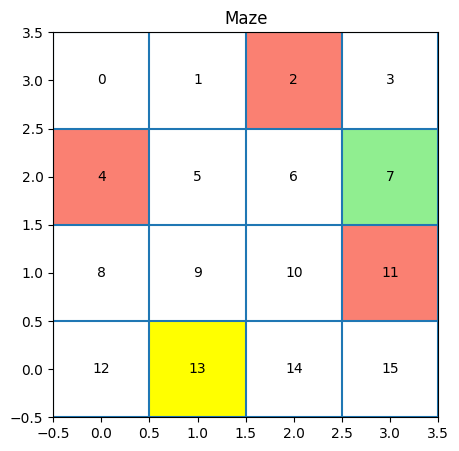

In [54]:
# Creating an agent object
agent = Agent(
    nrow_maze=4,
    ncol_maze=4,
    seed=2
)

# Initiating the maze 
agent.init_maze(maze_density=3)

# Ploting the maze 
plot_matrix(agent.S, goal_coords=agent.goal_coords, hole_coords=agent.wall_coords, start_coords=agent.start_coords, title="Maze")

There are in total 42 states, 13 of them are wall states. The agent wants to learn the values for actions in each of the free states that maximizes the total reward. 

The agent will start exploring from the 19th state and go to the 20th state.

## Initiating the agent 

In [55]:
# Letting the agent wonder for 1 episode 
agent.train_episodes(1)

print(f"The Q table after one episode: \n {agent.Q}")

The Q table after one episode: 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-01]
 [-1.00000000e+00 -1.00000000e-01  0.00000000e+00  7.81158917e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00900000e+00 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01]
 [-1.00000000e-01  2.95912972e+01 -1.00000000e-01 -1.00000000e-01]
 [-1.90000000e-01  8.55872235e+00 -4.96137910e-02 -1.00900000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.90000000e-01 -1.99000000e-01 -1.99000000e-01  1.51307440e+01]
 [ 4.38652661e+00 -1.99000000e-01  3.12378069e-01  8.89065464e+01]
 [ 4.99285012e-01  0.00000000

In [28]:
agent.action_name_dict

{0: 'up', 1: 'down', 2: 'left', 3: 'right'}

In [56]:
agent.state_visit_counter

{9: 9,
 10: 5,
 6: 3,
 2: 1,
 12: 6,
 8: 3,
 13: 14,
 14: 131,
 15: 124,
 11: 75,
 4: 1,
 5: 1,
 7: 1}

In [30]:
agent.get_state_coords(14)

(3, 2)

In [57]:
agent.Q[6]

array([-1.        , -0.1       ,  0.        ,  7.81158917])

In [59]:
agent.Q[14]

array([ 0.49928501,  0.        , 21.8110013 , 99.99955805])